In [1]:
import sys
import time
import argparse
import json
import numpy as np
import pandas as pd
# not compatible with pandas 1.1.0
# pip3 install --user -U pandas==1.0.5
# see https://github.com/limix/pandas-plink/issues/18
from pandas_plink import read_plink

from pprint import pprint

In [2]:
def BDF(prefix):
    (bim, fam, bed) = read_plink(prefix, verbose=True)
    bdf = pd.DataFrame(bed.compute().astype('int8')).join(bim[['snp']]).set_index('snp').append(fam.trait.astype('int8')).transpose()
    bdf.index.name = 'sampleId'
    bdf['trait'] = bdf.trait - 1
    return bdf

In [3]:
def PredictTree(sampleId, sample, treeId, tree, depth, res):
    
    size = tree['size']
    cCase = tree['classCounts'][0]
    pCase = cCase/size
    splitVar = 'NA'
    splitPoint= 'NA'
    gt = -1
    nextNode = 'NA'
    
    # Check if node is not a leaf
    if 'splitVar' in tree:
        splitVar = tree['splitVar'].replace("_", ":")
        splitPoint = int(tree['splitPoint'])
        
        # Check for allele order in the variable names
        if splitVar not in sample.index:
            x = splitVar.split(':')
            x[2], x[3] = x[3], x[2]
            splitVar = ':'.join(x)
        
        # If the variable is not found in the target data
        if splitVar not in sample.index:
            print("ERROR")
            exit()
            
        gt = int(sample[splitVar])
        
        nextNode = 'left'
        if(gt > splitPoint):
            nextNode = 'right'
    
    # Add prediction to the list
    res.append({'sampleId':sampleId, 'treeId':treeId, 'depth':depth, 'size':size, 
                'pCase':pCase, 'splitVar':splitVar, 'splitPoint':splitPoint, 
                'gt':gt, 'nextNode':nextNode, 'pheno':sample['trait']})
    
    if 'splitVar' in tree:
        PredictTree(sampleId, sample, treeId, tree[nextNode], depth+1, res)

In [4]:
def PredictForest(forest, sampleId, sample, res):
    for treeId, tree in enumerate(forest):
        PredictTree(sampleId, sample, treeId, tree['rootNode'], 0, res)

In [5]:
def PredictTarget(forest, bdf):
    res = list()
    
    cnt=0
    for sampleId in bdf.index:
        sample = bdf.loc[sampleId]
        PredictForest(forest, sampleId, sample, res)
        cnt += 1
        if(cnt%10 == 9):
            print(cnt)
    
    pdf = pd.DataFrame(res).set_index('sampleId')
    
    return pdf

In [16]:
def Algo0(pdf):
    pred = pdf.loc[pdf['splitVar'] == 'NA'].groupby(['sampleId']).mean()[['pCase','pheno']]
    return pred

In [17]:
def Algo1(pdf, depth):
    return pdf.loc[pdf['depth'] == depth].groupby(['sampleId']).mean()[['pCase','pheno']]

In [18]:
def Algo2(pdf, bdf):
    pdf = pdf.join(pdf.groupby(['sampleId']).sum()[['size']].rename(columns={'size':'totalSize'}))
    pdf['weight'] = pdf['size']/pdf.totalSize
    pdf['wpCase'] = pdf['weight']*pdf.pCase
    return pdf.groupby(['sampleId']).sum()[['wpCase']].join(bdf[['trait']])

In [9]:
bdf = BDF('YCC-0-BD')
bdf = bdf.sample(n=200, axis='index')

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 13.00it/s]


In [10]:
with open('RF-YCC-0-BD-1K.json', 'r') as json_file:
    rfModel = json.load(json_file)
    forest=rfModel['trees']

In [11]:
ydf = PredictTarget(forest, bdf)

9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199


In [12]:
ydf.to_csv('ydf.csv')

In [ ]:
# bdf = BDF('XCC-0-BD')
# bdf = bdf.sample(n=1, axis='index')

# xdf = PredictTarget(forest, bdf)

In [22]:
ydf.head(20)

,treeId,depth,size,pCase,splitVar,splitPoint,gt,nextNode,pheno
sampleId,,,,,,,,,
401,0,0,3867,0.607189,6:54010681:A:G,1,2,right,0
401,0,1,378,0.746032,17:30069203:G:A,1,0,left,0
401,0,2,297,0.801347,4:115656533:A:G,1,2,right,0
401,0,3,21,0.333333,20:54273528:T:C,0,2,right,0
401,0,4,14,0.000000,NA,NA,-1,NA,0
401,1,0,3867,0.619860,4:141995561:C:T,0,2,right,0
401,1,1,865,0.541040,16:86381184:G:C,0,2,right,0
401,1,2,338,0.420118,3:141047072:A:C,0,1,right,0
401,1,3,216,0.527778,8:70544235:G:C,0,2,right,0


In [25]:
pred = Algo0(ydf)
pred

,pCase,pheno
sampleId,,
9,0.522,0.0
23,0.483,0.0
50,0.489,0.0
71,0.501,0.0
79,0.505,0.0
...,...,...
3769,0.486,1.0
3770,0.506,1.0
3814,0.482,1.0


<AxesSubplot:xlabel='pheno', ylabel='pCase'>

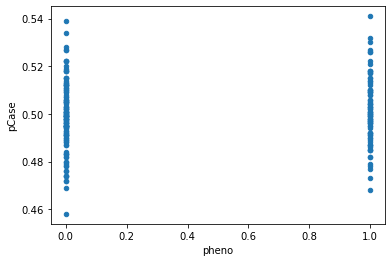

In [26]:
pred.plot.scatter(x='pheno', y='pCase')

In [29]:
pred = Algo1(ydf, 3)
pred

,pCase,pheno
sampleId,,
9,0.526358,0.0
23,0.528122,0.0
50,0.525764,0.0
71,0.518369,0.0
79,0.523695,0.0
...,...,...
3769,0.519112,1.0
3770,0.516155,1.0
3814,0.524537,1.0


<AxesSubplot:xlabel='pheno', ylabel='pCase'>

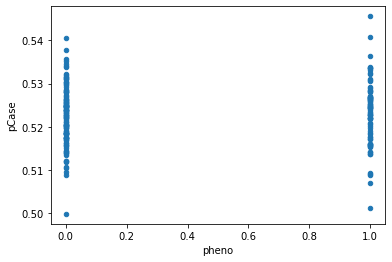

In [30]:
pred.plot.scatter(x='pheno', y='pCase')

In [33]:
pred = Algo2(ydf, bdf)
pred

,wpCase,trait
sampleId,,
9,0.606352,0
23,0.605997,0
50,0.607476,0
71,0.608031,0
79,0.608459,0
...,...,...
3769,0.607010,1
3770,0.606287,1
3814,0.606339,1


<AxesSubplot:xlabel='trait', ylabel='wpCase'>

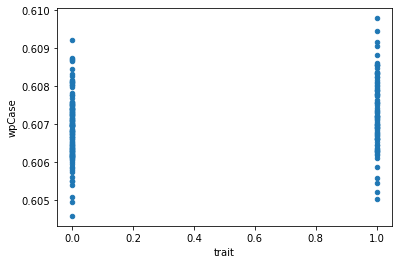

In [35]:
pred.plot.scatter(x='trait', y='wpCase')